In [2]:
import os
import numpy as np
from vendi_score import vendi
from pprint import pprint   
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
embedding_model = 'facebook_vjepa2-vitl-fpc64-256'
embedding_dir_dict = {
    'BabyView': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/babyview/{embedding_model}',
    'SAYCam': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/SAYCam/{embedding_model}',
    'Kinetics400': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/kinetics_train//{embedding_model}',
    'Ego4D': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/ego4D/{embedding_model}',
    'SSv2': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/ssv2/{embedding_model}',
    'MomentsInTime': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/Moments_in_Time_Raw_training/{embedding_model}',
    'Physion': f'/ccn2a/dataset/babyview/2025.2/outputs/video_embeddings/physion/{embedding_model}',
}

In [4]:
def get_num_files(embedding_dir):
    files = [f for f in os.listdir(embedding_dir) if f.endswith(".npy")]
    return len(files)

def load_embeddings(embedding_dir, num_samples=1000):
    files = [f for f in os.listdir(embedding_dir) if f.endswith(".npy")]
    files = np.random.choice(files, min(num_samples, len(files)), replace=False)
    X = np.stack([np.load(os.path.join(embedding_dir, f)) for f in files])  # (n, d)
    
    # # --- Z-score each column (feature) separately: X := (X - mean_col) / std_col ---
    # # mean_col, std_col have shape (1, d) so broadcasting works on (n, d).
    # mean_col = np.mean(X, axis=0, keepdims=True)
    # std_col = np.std(X, axis=0, keepdims=True)  # population std (ddof=0); use ddof=1 if you prefer sample std
    # std_col_safe = np.where(std_col < 1e-6, 1.0, std_col)  # replace small std with 1.0 to avoid division by zero
    # X = (X - mean_col) / std_col_safe
    # print('X:', X.shape)
    return X

def get_vendi_score(X): # score_dual uses the covariance (d×d) — fast & stable for normalized embeddings
    vs = vendi.score_dual(X, normalize=True)  # set normalize=True if rows aren’t L2-normalized
    return vs

def get_cosine_distance_score(X):
    sims = cosine_similarity(X)  # (n, n)
    mean_sim = np.mean(sims[np.triu_indices(len(sims), k=1)])  # mean of upper triangle, excluding diagonal
    return 1 - mean_sim


In [5]:
results = {}
embedding_dim = None
for dataset_name, embedding_dir in embedding_dir_dict.items():
    X = load_embeddings(embedding_dir)          # (n, 1024)
    embedding_dim = X.shape[1]
    num_files = get_num_files(embedding_dir)

    # Get scores
    vs = get_vendi_score(X) 
    cos_dist_score = get_cosine_distance_score(X)
    
    results[dataset_name] = {
        'num_files': num_files,
        'vendi_score': vs,
        'cosine_distance': cos_dist_score,
    }
    print(f'{dataset_name}: {num_files} files, Vendi score: {vs}, Cosine distance: {cos_dist_score}')

BabyView: 541392 files, Vendi score: 3.596527576446533, Cosine distance: 0.19187616617441616
SAYCam: 170821 files, Vendi score: 3.710509777069092, Cosine distance: 0.20539096130304613
Kinetics400: 235933 files, Vendi score: 9.395934104919434, Cosine distance: 0.34531601314414817
Ego4D: 2702 files, Vendi score: 5.811014652252197, Cosine distance: 0.3170139573587335
SSv2: 2521 files, Vendi score: 8.245766639709473, Cosine distance: 0.32145133797303116
MomentsInTime: 2435 files, Vendi score: 11.471266746520996, Cosine distance: 0.3848550341558803
Physion: 3363 files, Vendi score: 3.817601203918457, Cosine distance: 0.22585741197928277


## Plotting

         dataset  num_files  vendi_score  cosine_distance
0       BabyView     541392     3.596528         0.191876
1         SAYCam     170821     3.710510         0.205391
2    Kinetics400     235933     9.395934         0.345316
3          Ego4D       2702     5.811015         0.317014
4           SSv2       2521     8.245767         0.321451
5  MomentsInTime       2435    11.471267         0.384855
6        Physion       3363     3.817601         0.225857


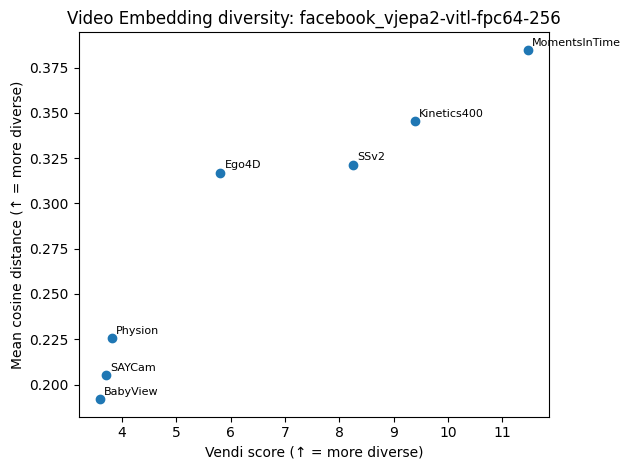

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Results → DataFrame -----------------------------------------------------
df = pd.DataFrame.from_dict(results, orient="index").reset_index()
df = df.rename(columns={"index": "dataset"})
print(df)

# (Optional) If all datasets used the same sample size in load_embeddings(),
# Vendi is directly comparable. If NOT, normalize by the sample size you used.
# Example, if you stored it: df["vendi_norm"] = df["vendi_score"] / df["n_used"]

# ---- 1) Scatter: Vendi vs cosine distance -----------------------------------
plt.figure()
plt.scatter(df["vendi_score"], df["cosine_distance"])
for _, row in df.iterrows():
    plt.annotate(row["dataset"], (row["vendi_score"], row["cosine_distance"]), fontsize=8,
                 xytext=(3, 3), textcoords="offset points")
plt.xlabel("Vendi score (↑ = more diverse)")
plt.ylabel("Mean cosine distance (↑ = more diverse)")
plt.title(f"Video Embedding diversity: {embedding_model}")
plt.tight_layout()
plt.show()